# FHIC: Fast Hyperspectral Image Classification Model Using ETR Dimensionality Reduction and ELU Activation Function

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install spectral

In [3]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv



import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral


import pandas as pd
import time
import seaborn as sn

#init_notebook_mode(connected=True)
%matplotlib inline

# Data Loading

In [4]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/data/')
    #data_path = os.path.join(os.getcwd(),'..\data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'KSC':
        data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
        labels = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
    elif name == 'LK':
        data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
        labels = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
    elif name == 'HC':
        data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        labels = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
    elif name == 'HH':
        data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HongHu.mat'))['WHU_Hi_HongHu']
        labels = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HongHu_gt.mat'))['WHU_Hi_HongHu_gt']
    elif name == 'Di':
        data = sio.loadmat(os.path.join(data_path, 'Dioni.mat'))['Dioni']
        labels = sio.loadmat(os.path.join(data_path, 'Dioni_GT.mat'))['Dioni_gt']
    elif name == 'Lk':
        data = sio.loadmat(os.path.join(data_path, 'Loukia.mat'))['Loukia']
        labels = sio.loadmat(os.path.join(data_path, 'Loukia_GT.mat'))['Loukia_gt']
    elif name == 'HS':
        data = sio.loadmat(os.path.join(data_path, 'Houston.mat'))['Houston']
        labels = sio.loadmat(os.path.join(data_path, 'Houston_gt1.mat'))['gt']
    return data, labels

In [5]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [6]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']

  return df


In [10]:
def second_step(X, orgin, numComponents):

  correlation_matrix = np.corrcoef(orgin.T)

  covariance_matrix = np.cov(X.T)
  print(correlation_matrix.shape, covariance_matrix.shape)
  final_matrix = covariance_matrix - correlation_matrix
  print(max(pd.DataFrame(final_matrix)))

  # Eigendecomposition of the covariance
  eigen_values, eigen_vectors = np.linalg.eig(final_matrix)

  # Calculate the variance explained on each of those components
  variance_explained = [(i/sum(eigen_values))*100 for i in eigen_values]

  # Calculate the cumulative sum of variance explained
  cumulative_variance_explained = np.cumsum(variance_explained)

  #Taking two components and create a projection matrix
  projection_matrix = (eigen_vectors.T[:][:numComponents]).T


  X_t = X.dot(projection_matrix)

  return X_t

In [11]:
from numpy.core.fromnumeric import shape
from skimage.morphology import reconstruction
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

def ETR(X1, y1, band_no, numComponents):

  df = extract_pixels(X1, y1)
  X = df.iloc[:, :-1]
  y = df.iloc[:, -1]

  X = second_step(X,X.iloc[:, :], numComponents)

  X_mean = X
  X_mean['mean'] = X_mean.mean(axis=1)
  Avr = [X_mean['mean']]
  rep_Avr = np.repeat(Avr, numComponents)
  rep_Avr =np.reshape(rep_Avr, (-1,numComponents))
  main_X = X.iloc[:, :-1]
  seed = main_X - rep_Avr

  dilated = reconstruction(seed.values, main_X.values)

  scaler = QuantileTransformer(n_quantiles=15, random_state=0,output_distribution='normal') #
  scaler = scaler.fit_transform(dilated)

  return scaler, y

In [12]:
def rename_features(X, y):
  q = X.reshape(-1, X.shape[1])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'{i}' for i in range(1, 1+X.shape[1])]+['class']

  return df

In [13]:
dataset = 'IP'
output_units = 16
min_no = 0.30
test_ratio = 0.8
windowSize = 15

X, y11 = loadData(dataset)

h1 = X.shape[0]
w1 = X.shape[1]
X.shape, y11.shape

((145, 145, 200), (145, 145))

In [14]:
import time
numComponents = 15
K = numComponents
band_no = X.shape[2]

training_start_time = time.time()

X1, y1 = ETR(X,y11, band_no, numComponents) #IP
training_end_time = time.time()

X1.shape, y1.shape

(200, 200) (200, 200)
199


((21025, 15), (21025,))

In [15]:
print("preprocessing time : ", training_end_time - training_start_time )
preprocessing_time = training_end_time - training_start_time

preprocessing time :  0.559788703918457


In [16]:
rd = rename_features(X1, y11)
rd.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,class
0,-0.681017,-0.117213,-0.165398,-0.163168,0.770929,-0.366106,-0.275649,0.638835,-5.199338,-0.241861,-0.791639,-0.074402,-0.506272,0.663284,0.089642,3
1,-0.941034,0.594557,-0.645917,0.912717,-0.173378,-0.366106,-0.468446,-0.517242,-5.199338,0.425117,-0.791639,0.010431,-0.353500,0.137774,0.089642,3
2,-1.055659,0.594557,-0.870452,1.310650,-0.445689,-0.366106,-0.380525,-0.411731,-5.199338,-0.664315,-0.791639,-0.195853,-0.123935,-0.358898,0.089642,3
3,-0.932617,0.594557,-0.655573,0.876248,-0.170343,-0.366106,-0.610060,-0.499126,-5.199338,0.280670,-0.791639,0.179675,-0.221758,0.087474,0.089642,3
4,-0.683179,0.469569,-0.014294,0.172666,0.654369,-0.366106,-1.342540,0.812837,-5.199338,-0.245559,-0.791639,0.278416,0.210041,0.136585,0.089642,3


In [17]:
# to reorder the features

lst = range(1, numComponents+1)

# Convert the integers to strings.
lst = list(map(str, lst))

# Sort the list first by even numbers in descending order, and then by odd numbers in ascending order.
sorted_lst = sorted(lst, key=lambda x: (int(x) % 2 == 0, int(x) if int(x) % 2 == 0 else -int(x)), reverse=True)

print(sorted_lst)

['14', '12', '10', '8', '6', '4', '2', '1', '3', '5', '7', '9', '11', '13', '15']


In [18]:
input_data3 = rd[sorted_lst]
input_data3.head()

,14,12,10,8,6,4,2,1,3,5,7,9,11,13,15
0,0.663284,-0.074402,-0.241861,0.638835,-0.366106,-0.163168,-0.117213,-0.681017,-0.165398,0.770929,-0.275649,-5.199338,-0.791639,-0.506272,0.089642
1,0.137774,0.010431,0.425117,-0.517242,-0.366106,0.912717,0.594557,-0.941034,-0.645917,-0.173378,-0.468446,-5.199338,-0.791639,-0.353500,0.089642
2,-0.358898,-0.195853,-0.664315,-0.411731,-0.366106,1.310650,0.594557,-1.055659,-0.870452,-0.445689,-0.380525,-5.199338,-0.791639,-0.123935,0.089642
3,0.087474,0.179675,0.280670,-0.499126,-0.366106,0.876248,0.594557,-0.932617,-0.655573,-0.170343,-0.610060,-5.199338,-0.791639,-0.221758,0.089642
4,0.136585,0.278416,-0.245559,0.812837,-0.366106,0.172666,0.469569,-0.683179,-0.014294,0.654369,-1.342540,-5.199338,-0.791639,0.210041,0.089642


In [19]:
scaler = QuantileTransformer(n_quantiles=15, random_state=0,output_distribution='normal') #
scaler = scaler.fit_transform(input_data3)
scaler = np.reshape(scaler, (h1, w1, numComponents))


In [20]:
scaler.shape

(145, 145, 15)

In [21]:
X, y = createImageCubes(scaler, y11, windowSize=windowSize)

X.shape, y.shape

((10249, 15, 15, 15), (10249,))

In [22]:

Xtrain, Xtest, ytrain1, ytest1 = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain1.shape, ytest1.shape

((2049, 15, 15, 15), (8200, 15, 15, 15), (2049,), (8200,))

# Model and Training

In [23]:
ytrain = to_categorical(ytrain1)
ytrain.shape

(2049, 16)

In [24]:
S = windowSize
L = K


In [25]:
## input layer
from tensorflow.keras import regularizers
input_layer = Input((S, S, L))


conv_layer1 = Conv2D(filters=50, kernel_size=(5, 5), activation='elu')(input_layer)
conv_layer2 = Conv2D(filters=100, kernel_size=(5, 5), activation='elu')(conv_layer1)

conv_layer2 = keras.layers.MaxPooling2D(pool_size=(2, 2)) (conv_layer2)

flatten_layer = Flatten()(conv_layer2)
## fully connected layers
dense_layer1 = Dense(units=100, kernel_regularizer=regularizers.l2(0.001), activation='elu')(flatten_layer)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer1)

In [26]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 15, 15)]      0         
                                                                 
 conv2d (Conv2D)             (None, 11, 11, 50)        18800     
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 100)         125100    
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 100)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 dense (Dense)               (None, 100)               90100     
                                                             

In [28]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [29]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [30]:
import time

start = time.time()
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)
end1 = time.time()


Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 2.4362 - accuracy: 0.3572

9/9 [==============================] - 12s 37ms/step - loss: 2.4362 - accuracy: 0.3572
Epoch 2/100
8/9 [=========================>....] - ETA: 0s - loss: 1.3169 - accuracy: 0.6313

9/9 [==============================] - 0s 20ms/step - loss: 1.3164 - accuracy: 0.6315
Epoch 3/100
8/9 [=========================>....] - ETA: 0s - loss: 0.8869 - accuracy: 0.7603

9/9 [==============================] - 0s 17ms/step - loss: 0.8865 - accuracy: 0.7604
Epoch 4/100
4/9 [============>.................] - ETA: 0s - loss: 0.7048 - accuracy: 0.8379

9/9 [==============================] - 0s 15ms/step - loss: 0.6478 - accuracy: 0.8580
Epoch 5/100
5/9 [===============>..............] - ETA: 0s - loss: 0.4801 - accuracy: 0.9109

9/9 [==============================] - 0s 15ms/step - loss: 0.4838 - accuracy: 0.9141
Epoch 6/100
6/9 [===================>..........] - ETA: 0s - loss: 0.4693 - accuracy: 0.9036

9/9 [==============================] - 0s 13ms/step - loss: 0.4551 - accuracy: 0.9068
Epoch 7/100
6/9 [===================>..........] - ETA: 0s - loss: 0.3688 - accuracy: 0.9473

9/9 [==============================] - 0s 12ms/step - loss: 0.3553 - accuracy: 0.9531
Epoch 8/100
6/9 [===================>..........] - ETA: 0s - loss: 0.2923 - accuracy: 0.9766

9/9 [==============================] - 0s 12ms/step - loss: 0.2955 - accuracy: 0.9756
Epoch 9/100
6/9 [===================>..........] - ETA: 0s - loss: 0.2674 - accuracy: 0.9792

9/9 [==============================] - 0s 13ms/step - loss: 0.2675 - accuracy: 0.9790
Epoch 10/100
9/9 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.9863

9/9 [==============================] - 0s 19ms/step - loss: 0.2493 - accuracy: 0.9863
Epoch 11/100
6/9 [===================>..........] - ETA: 0s - loss: 0.2180 - accuracy: 0.9922

9/9 [==============================] - 0s 16ms/step - loss: 0.2188 - accuracy: 0.9932
Epoch 12/100
8/9 [=========================>....] - ETA: 0s - loss: 0.2085 - accuracy: 0.9971

9/9 [==============================] - 0s 16ms/step - loss: 0.2085 - accuracy: 0.9971
Epoch 13/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1998 - accuracy: 0.9987

9/9 [==============================] - 0s 11ms/step - loss: 0.1981 - accuracy: 0.9990
Epoch 14/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1917 - accuracy: 1.0000

9/9 [==============================] - 0s 12ms/step - loss: 0.1905 - accuracy: 1.0000
Epoch 15/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1984 - accuracy: 0.9974

9/9 [==============================] - 0s 11ms/step - loss: 0.1959 - accuracy: 0.9976
Epoch 16/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1932 - accuracy: 0.9967

9/9 [==============================] - 0s 12ms/step - loss: 0.1923 - accuracy: 0.9971
Epoch 17/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1870 - accuracy: 0.9985

9/9 [==============================] - 0s 16ms/step - loss: 0.1870 - accuracy: 0.9985
Epoch 18/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1801 - accuracy: 1.0000

9/9 [==============================] - 0s 18ms/step - loss: 0.1801 - accuracy: 1.0000
Epoch 19/100
5/9 [===============>..............] - ETA: 0s - loss: 0.1818 - accuracy: 0.9977

9/9 [==============================] - 0s 13ms/step - loss: 0.1810 - accuracy: 0.9980
Epoch 20/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1779 - accuracy: 0.9993

9/9 [==============================] - 0s 12ms/step - loss: 0.1771 - accuracy: 0.9995
Epoch 21/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1734 - accuracy: 1.0000

9/9 [==============================] - 0s 12ms/step - loss: 0.1732 - accuracy: 1.0000
Epoch 22/100
5/9 [===============>..............] - ETA: 0s - loss: 0.1712 - accuracy: 1.0000

9/9 [==============================] - 0s 13ms/step - loss: 0.1710 - accuracy: 1.0000
Epoch 23/100
5/9 [===============>..............] - ETA: 0s - loss: 0.1689 - accuracy: 1.0000

9/9 [==============================] - 0s 14ms/step - loss: 0.1686 - accuracy: 1.0000
Epoch 24/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1668 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.1668 - accuracy: 1.0000
Epoch 25/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1649 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.1649 - accuracy: 1.0000
Epoch 26/100
5/9 [===============>..............] - ETA: 0s - loss: 0.1635 - accuracy: 1.0000

9/9 [==============================] - 0s 15ms/step - loss: 0.1633 - accuracy: 1.0000
Epoch 27/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1616 - accuracy: 1.0000

9/9 [==============================] - 0s 17ms/step - loss: 0.1616 - accuracy: 1.0000
Epoch 28/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1664 - accuracy: 0.9987

9/9 [==============================] - 0s 21ms/step - loss: 0.1649 - accuracy: 0.9990
Epoch 29/100
9/9 [==============================] - ETA: 0s - loss: 0.1602 - accuracy: 1.0000

9/9 [==============================] - 0s 15ms/step - loss: 0.1602 - accuracy: 1.0000
Epoch 30/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1576 - accuracy: 1.0000

9/9 [==============================] - 0s 19ms/step - loss: 0.1576 - accuracy: 1.0000
Epoch 31/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1559 - accuracy: 1.0000

9/9 [==============================] - 0s 13ms/step - loss: 0.1557 - accuracy: 1.0000
Epoch 32/100
5/9 [===============>..............] - ETA: 0s - loss: 0.1542 - accuracy: 1.0000

9/9 [==============================] - 0s 15ms/step - loss: 0.1539 - accuracy: 1.0000
Epoch 33/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1522 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.1522 - accuracy: 1.0000
Epoch 34/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1505 - accuracy: 1.0000

9/9 [==============================] - 0s 17ms/step - loss: 0.1505 - accuracy: 1.0000
Epoch 35/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1489 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.1489 - accuracy: 1.0000
Epoch 36/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1473 - accuracy: 1.0000

9/9 [==============================] - 0s 18ms/step - loss: 0.1473 - accuracy: 1.0000
Epoch 37/100
5/9 [===============>..............] - ETA: 0s - loss: 0.1460 - accuracy: 1.0000

9/9 [==============================] - 0s 13ms/step - loss: 0.1457 - accuracy: 1.0000
Epoch 38/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1442 - accuracy: 1.0000

9/9 [==============================] - 0s 20ms/step - loss: 0.1442 - accuracy: 1.0000
Epoch 39/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1427 - accuracy: 1.0000

9/9 [==============================] - 0s 18ms/step - loss: 0.1426 - accuracy: 1.0000
Epoch 40/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1410 - accuracy: 1.0000

9/9 [==============================] - 0s 20ms/step - loss: 0.1410 - accuracy: 1.0000
Epoch 41/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1395 - accuracy: 1.0000

9/9 [==============================] - 0s 20ms/step - loss: 0.1394 - accuracy: 1.0000
Epoch 42/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1380 - accuracy: 1.0000

9/9 [==============================] - 0s 20ms/step - loss: 0.1378 - accuracy: 1.0000
Epoch 43/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1364 - accuracy: 1.0000

9/9 [==============================] - 0s 23ms/step - loss: 0.1363 - accuracy: 1.0000
Epoch 44/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1353 - accuracy: 1.0000

9/9 [==============================] - 0s 24ms/step - loss: 0.1353 - accuracy: 1.0000
Epoch 45/100
9/9 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 1.0000

9/9 [==============================] - 0s 23ms/step - loss: 0.1338 - accuracy: 1.0000
Epoch 46/100
9/9 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 1.0000

9/9 [==============================] - 0s 25ms/step - loss: 0.1346 - accuracy: 1.0000
Epoch 47/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1349 - accuracy: 0.9989

9/9 [==============================] - 0s 21ms/step - loss: 0.1343 - accuracy: 0.9990
Epoch 48/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1300 - accuracy: 0.9995

9/9 [==============================] - 0s 20ms/step - loss: 0.1300 - accuracy: 0.9995
Epoch 49/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1277 - accuracy: 1.0000

9/9 [==============================] - 0s 26ms/step - loss: 0.1276 - accuracy: 1.0000
Epoch 50/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1259 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.1258 - accuracy: 1.0000
Epoch 51/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1243 - accuracy: 1.0000

9/9 [==============================] - 0s 18ms/step - loss: 0.1242 - accuracy: 1.0000
Epoch 52/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1226 - accuracy: 1.0000

9/9 [==============================] - 0s 17ms/step - loss: 0.1226 - accuracy: 1.0000
Epoch 53/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1210 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.1210 - accuracy: 1.0000
Epoch 54/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1196 - accuracy: 1.0000

9/9 [==============================] - 0s 17ms/step - loss: 0.1195 - accuracy: 1.0000
Epoch 55/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1181 - accuracy: 1.0000

9/9 [==============================] - 0s 23ms/step - loss: 0.1180 - accuracy: 1.0000
Epoch 56/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1166 - accuracy: 1.0000

9/9 [==============================] - 0s 17ms/step - loss: 0.1166 - accuracy: 1.0000
Epoch 57/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1152 - accuracy: 1.0000

9/9 [==============================] - 0s 21ms/step - loss: 0.1151 - accuracy: 1.0000
Epoch 58/100
9/9 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 1.0000

9/9 [==============================] - 0s 25ms/step - loss: 0.1136 - accuracy: 1.0000
Epoch 59/100
9/9 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 1.0000

9/9 [==============================] - 0s 23ms/step - loss: 0.1122 - accuracy: 1.0000
Epoch 60/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1109 - accuracy: 1.0000

9/9 [==============================] - 0s 22ms/step - loss: 0.1107 - accuracy: 1.0000
Epoch 61/100
9/9 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.1093 - accuracy: 1.0000
Epoch 62/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1079 - accuracy: 1.0000

9/9 [==============================] - 0s 18ms/step - loss: 0.1079 - accuracy: 1.0000
Epoch 63/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1066 - accuracy: 1.0000

9/9 [==============================] - 0s 23ms/step - loss: 0.1065 - accuracy: 1.0000
Epoch 64/100
9/9 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 1.0000

9/9 [==============================] - 0s 25ms/step - loss: 0.1051 - accuracy: 1.0000
Epoch 65/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1038 - accuracy: 1.0000

9/9 [==============================] - 0s 19ms/step - loss: 0.1037 - accuracy: 1.0000
Epoch 66/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1024 - accuracy: 1.0000

9/9 [==============================] - 0s 19ms/step - loss: 0.1023 - accuracy: 1.0000
Epoch 67/100
7/9 [======================>.......] - ETA: 0s - loss: 0.1011 - accuracy: 1.0000

9/9 [==============================] - 0s 22ms/step - loss: 0.1010 - accuracy: 1.0000
Epoch 68/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0999 - accuracy: 1.0000

9/9 [==============================] - 0s 34ms/step - loss: 0.0998 - accuracy: 1.0000
Epoch 69/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0983 - accuracy: 1.0000

9/9 [==============================] - 0s 27ms/step - loss: 0.0983 - accuracy: 1.0000
Epoch 70/100
6/9 [===================>..........] - ETA: 0s - loss: 0.0971 - accuracy: 1.0000

9/9 [==============================] - 0s 20ms/step - loss: 0.0970 - accuracy: 1.0000
Epoch 71/100
9/9 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9995

9/9 [==============================] - 0s 28ms/step - loss: 0.0973 - accuracy: 0.9995
Epoch 72/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0949 - accuracy: 1.0000

9/9 [==============================] - 0s 19ms/step - loss: 0.0948 - accuracy: 1.0000
Epoch 73/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0933 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.0933 - accuracy: 1.0000
Epoch 74/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0919 - accuracy: 1.0000

9/9 [==============================] - 0s 17ms/step - loss: 0.0919 - accuracy: 1.0000
Epoch 75/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0927 - accuracy: 1.0000

9/9 [==============================] - 0s 22ms/step - loss: 0.0926 - accuracy: 1.0000
Epoch 76/100
9/9 [==============================] - ETA: 0s - loss: 0.0935 - accuracy: 0.9990

9/9 [==============================] - 0s 16ms/step - loss: 0.0935 - accuracy: 0.9990
Epoch 77/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0898 - accuracy: 1.0000

9/9 [==============================] - 0s 18ms/step - loss: 0.0898 - accuracy: 1.0000
Epoch 78/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0883 - accuracy: 1.0000

9/9 [==============================] - 0s 18ms/step - loss: 0.0883 - accuracy: 1.0000
Epoch 79/100
6/9 [===================>..........] - ETA: 0s - loss: 0.0868 - accuracy: 1.0000

9/9 [==============================] - 0s 13ms/step - loss: 0.0865 - accuracy: 1.0000
Epoch 80/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0852 - accuracy: 1.0000

9/9 [==============================] - 0s 17ms/step - loss: 0.0851 - accuracy: 1.0000
Epoch 81/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0837 - accuracy: 1.0000

9/9 [==============================] - 0s 19ms/step - loss: 0.0837 - accuracy: 1.0000
Epoch 82/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0943 - accuracy: 0.9967

9/9 [==============================] - 0s 20ms/step - loss: 0.0930 - accuracy: 0.9971
Epoch 83/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0881 - accuracy: 0.9990

9/9 [==============================] - 0s 17ms/step - loss: 0.0881 - accuracy: 0.9990
Epoch 84/100
5/9 [===============>..............] - ETA: 0s - loss: 0.0862 - accuracy: 0.9992

9/9 [==============================] - 0s 13ms/step - loss: 0.0850 - accuracy: 0.9995
Epoch 85/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0835 - accuracy: 0.9995

9/9 [==============================] - 0s 18ms/step - loss: 0.0835 - accuracy: 0.9995
Epoch 86/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0823 - accuracy: 1.0000

9/9 [==============================] - 0s 20ms/step - loss: 0.0822 - accuracy: 1.0000
Epoch 87/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0788 - accuracy: 1.0000

9/9 [==============================] - 0s 21ms/step - loss: 0.0786 - accuracy: 1.0000
Epoch 88/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0777 - accuracy: 1.0000

9/9 [==============================] - 0s 21ms/step - loss: 0.0775 - accuracy: 1.0000
Epoch 89/100
6/9 [===================>..........] - ETA: 0s - loss: 0.1054 - accuracy: 0.9902

9/9 [==============================] - 0s 20ms/step - loss: 0.1334 - accuracy: 0.9868
Epoch 90/100
8/9 [=========================>....] - ETA: 0s - loss: 0.2430 - accuracy: 0.9556

9/9 [==============================] - 0s 18ms/step - loss: 0.2429 - accuracy: 0.9556
Epoch 91/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1554 - accuracy: 0.9727

9/9 [==============================] - 0s 16ms/step - loss: 0.1553 - accuracy: 0.9727
Epoch 92/100
8/9 [=========================>....] - ETA: 0s - loss: 0.1196 - accuracy: 0.9883

9/9 [==============================] - 0s 16ms/step - loss: 0.1196 - accuracy: 0.9883
Epoch 93/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0952 - accuracy: 0.9972

9/9 [==============================] - 0s 19ms/step - loss: 0.0950 - accuracy: 0.9971
Epoch 94/100
7/9 [======================>.......] - ETA: 0s - loss: 0.0906 - accuracy: 0.9961

9/9 [==============================] - 0s 23ms/step - loss: 0.0899 - accuracy: 0.9961
Epoch 95/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0802 - accuracy: 0.9995

9/9 [==============================] - 0s 17ms/step - loss: 0.0802 - accuracy: 0.9995
Epoch 96/100
5/9 [===============>..............] - ETA: 0s - loss: 0.0764 - accuracy: 1.0000

9/9 [==============================] - 0s 16ms/step - loss: 0.0762 - accuracy: 1.0000
Epoch 97/100
5/9 [===============>..............] - ETA: 0s - loss: 0.0747 - accuracy: 1.0000

9/9 [==============================] - 0s 14ms/step - loss: 0.0745 - accuracy: 1.0000
Epoch 98/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0734 - accuracy: 1.0000

9/9 [==============================] - 0s 19ms/step - loss: 0.0734 - accuracy: 1.0000
Epoch 99/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0721 - accuracy: 1.0000

9/9 [==============================] - 0s 21ms/step - loss: 0.0721 - accuracy: 1.0000
Epoch 100/100
8/9 [=========================>....] - ETA: 0s - loss: 0.0711 - accuracy: 1.0000

9/9 [==============================] - 0s 20ms/step - loss: 0.0711 - accuracy: 1.0000


In [31]:
Train_time1 = end1 - start

print(Train_time1)

41.76221227645874


# ***Validation***

In [32]:
import pandas as pd
import numpy as np
import time
import seaborn as sn

ac = history.history['accuracy']
accuracy_report = pd.DataFrame(ac)
accuracy_report.to_csv(dataset+'_FHIC Model accuracy.csv', index= False)

In [33]:
ls = history.history['loss']
accuracy_report = pd.DataFrame(ls)
accuracy_report.to_csv(dataset+'_FHIC Model loss.csv', index= False)

In [34]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [35]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K)
Xtest.shape

(8200, 15, 15, 15)

In [36]:
ytest = to_categorical(ytest1)
ytest.shape

(8200, 16)

In [37]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

257/257 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.99      0.98      0.99      1143
           2       0.99      1.00      0.99       664
           3       0.98      1.00      0.99       190
           4       0.97      0.99      0.98       386
           5       0.99      1.00      0.99       584
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00       382
           8       1.00      0.94      0.97        16
           9       0.98      0.98      0.98       778
          10       0.99      0.99      0.99      1964
          11       1.00      0.97      0.98       475
          12       1.00      1.00      1.00       164
          13       0.99      1.00      1.00      1012
          14       0.99      0.99      0.99       309
          15       0.99      0.99      0.99        74

    accuracy             

In [38]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [39]:
def reports (X_test,y_test,name):
    start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    end = time.time()

    TESTING_TIME = end - start
    print(TESTING_TIME)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'KSC':
        target_names = ["Scrub", "Willow swamp",
                        "Cabbage palm hammock", "Cabbage palm/oak hammock",
                        "Slash pine", "Oak/broadleaf hammock",
                        "Hardwood swamp", "Graminoid marsh", "Spartina marsh",
                        "Cattail marsh", "Salt marsh", "Mud flats", "Wate"]
    elif name == 'LK':
        target_names = ["Corn", "Cotton",
                        "Sesame", "Broad-leaf soybean",
                        "Narrow-leaf soybean", "Rice",
                        "Water", "Roads and houses", "Mixed weed"]
    elif name == 'HC':
        target_names = ["Strawberry", "Cowpea",
                        "Soybean", "Sorghum",
                        "Water spinach", "Watermelon",
                        "Greens", "Trees", "Grass",
                        "Red roof", "Gray roof", "Plastic", "Bare soil", "Road", "Bright object", "Water"]
    elif name == 'HH':
        target_names = ["Red roof", "Road", "Bare soil", "Cotton", "Cotton firewood", "Rape", "Chinese cabbage",
                        "Pakchoi", "Cabbage", "Tuber mustard", "Brassica parachinensis", "Brassica chinensis",
                        "Small Brassica chinensis",  "Lactuca sativa","Celtuce","Film covered lettuce","Romaine lettuce",
                        "Carrot","White radish","Garlic sprout","Broad bean","Tree"]
    elif name == 'Di':
        target_names = ["Dense Urban Fabric", "Mineral Extraction Sites",
                        "Non Irrigated Arable Land", "Fruit Trees",
                        "Olive Groves", "Coniferous Forest",
                        "Dense Sclerophyllous Vegetation", "Sparce Sclerophyllous Vegetation", "Sparcely Vegetated Areas",
                        "Rocks and Sand", "Water", "Coastal Water"]
    elif name == 'Lk':
        target_names = ["Dense Urban Fabric", "Mineral Extraction Sites",
                        "Non Irrigated Arable Land", "Fruit Trees",
                        "Olive Groves","Broad-Leaved Forest", "Coniferous Forest","Mixed Forest",
                        "Dense Sclerophyllous Vegetation", "Sparce Sclerophyllous Vegetation", "Sparcely Vegetated Areas",
                        "Rocks and Sand", "Water", "Coastal Water"]

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    ###################################
    clsf_report = pd.DataFrame(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names, output_dict=True)).transpose()
    clsf_report.to_csv(dataset+'_FHIC Model Classification Report.csv', index= True)
    #########################
    df_cm = pd.DataFrame(confusion, columns=np.unique(target_names), index = np.unique(target_names))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,8))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
    plt.savefig('confusion_matrix_FHIC_model.png', dpi=300)
    ##############
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return TESTING_TIME, classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

257/257 [==============================] - 1s 2ms/step
0.9647238254547119
257/257 [==============================] - 1s 3ms/step - loss: 0.1033 - accuracy: 0.9902


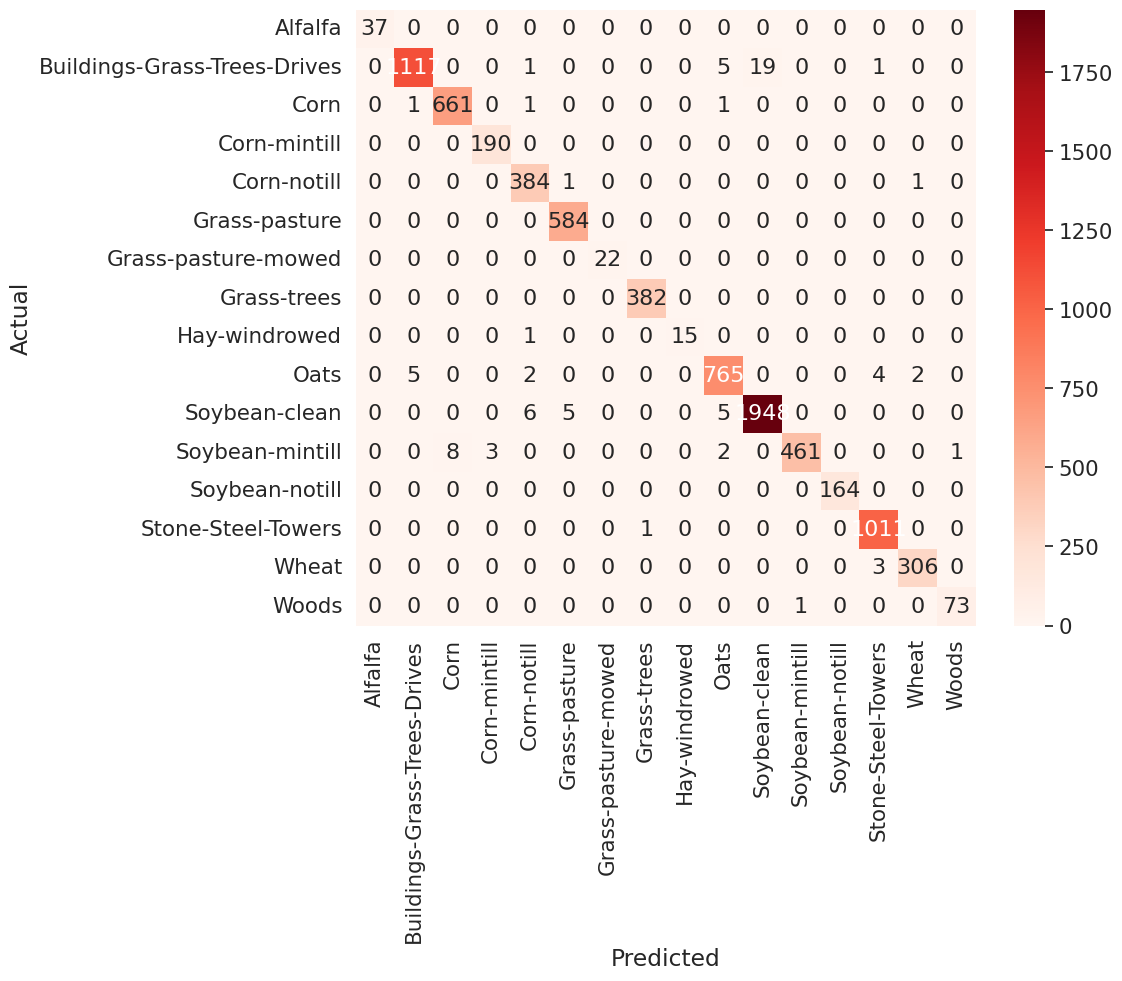

In [40]:
TESTING_TIME, classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
df_clas = classification
classification = str(classification)
confusion = str(confusion)
element_mean = np.mean(each_acc, axis=0)
element_std = np.std(each_acc, axis=0)
file_name = dataset+"_FHIC.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} preprocessing time (s): '.format(preprocessing_time))
    x_file.write('\n')
    x_file.write('{} Training Time (%)'.format(Train_time1))
    x_file.write('\n')
    x_file.write('{} Test Time (%)'.format(TESTING_TIME))
    x_file.write('\n')
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('{}+{} mean_KAPPA ± std_KAPPA is:'.format(str(np.mean(kappa)), str(np.std(kappa))))
    x_file.write('\n')
    x_file.write('{}+{} mean_OA ± std_OA is: (%)'.format(str(np.mean(oa)), str(np.std(oa))))
    x_file.write('\n')
    x_file.write('{}+{} mean_AA ± std_AA is:'.format(str(np.mean(aa)), str(np.std(aa))))
    x_file.write('\n')
    x_file.write('{} AMean of all elements in confusion matrix: (%)'.format(str(element_mean)))
    x_file.write('\n')
    x_file.write('{} Standard deviation of all elements in confusion matrix: (%)'.format(str(element_std)))
    x_file.write('\n')
    x_file.write('==============================\n')
    x_file.write('{}classification Report:'.format(classification))
    x_file.write('\n')
    x_file.write('===============================\n')
    x_file.write('{} confusion Matrix:'.format(confusion))